In [1]:
!pip install pandas sqlalchemy psycopg2-binary matplotlib seaborn geopandas folium mapclassify matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from sqlalchemy import create_engine

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
# Replace 'markfinlay', '<password>', 'localhost', '5432', and 'osm_data' with your details.
engine = create_engine('postgresql://markfinlay:@localhost:5432/osm_data')

query = """
    SELECT name, surface, width, tags, way, ST_Length(way) AS length_m FROM planet_osm_line
    WHERE (highway IN ('path', 'footway') OR route = 'hiking')
    AND way IS NOT NULL
    AND NOT ST_IsEmpty(way)
    AND ST_Length(way) > 1000
    AND surface IS NOT NULL
    ORDER BY osm_id;;"""

# Test the connection by reading a small sample from the table
df = pd.read_sql(query, engine)
df.count()

name         415
surface     2771
width        248
tags        2771
way         2771
length_m    2771
dtype: int64

In [4]:
df.head()

name   surface width                                               tags  \
0  None   asphalt  None  {'lit': 'yes', 'osm_uid': '0', 'osm_user': '',...   
1  None  concrete  None  {'lit': 'yes', 'kerb': 'yes', 'footway': 'side...   
2  None  concrete  None  {'lit': 'yes', 'kerb': 'yes', 'footway': 'side...   
3  None   asphalt  None  {'lit': 'no', 'osm_uid': '0', 'osm_user': '', ...   
4  None  concrete  None  {'lit': 'yes', 'kerb': 'yes', 'footway': 'side...   

                                                 way     length_m  
0  0102000020110F00001B0000006CDC3F50F79F24C1B68E...  1054.641527  
1  0102000020110F00003D000000A4BD6727053625C162EC...  1542.445410  
2  0102000020110F00003F0000005F384382C67725C1628B...  2780.692745  
3  0102000020110F00002900000006C8ABD0DF1424C13A53...  2156.734149  
4  0102000020110F000028000000A9295B0DB17B25C1D52D...  1992.201826

In [5]:
df['length_m'].describe()

count     2771.000000
mean      1870.347898
std       1113.182606
min       1000.115196
25%       1190.623449
50%       1503.510064
75%       2118.189588
max      14337.806816
Name: length_m, dtype: float64

In [6]:
df['surface'].value_counts()

surface
concrete                     901
asphalt                      416
gravel                       261
dirt                         251
unpaved                      213
ground                       202
grass                        189
compacted                     82
paved                         63
fine_gravel                   60
sand                          33
mud                           20
paving_stones                 17
wood                          12
rock                          11
earth                          8
concrete:plates                5
sand;pebbles                   4
dirt/sand                      4
pebblestone                    3
earth,_tree_roots,_stones      2
stone                          2
cobblestone                    2
cobblestone:flattened          1
aggregate                      1
concrete_with_bitumen          1
peat                           1
dirt; gravel; dirt             1
gravel_and_rock                1
grass, ground, gravel          1
bo

In [7]:
import geopandas as gpd

gdf = gpd.read_postgis(query, engine, geom_col='way')
# Convert to WGS84 so that the GeoJSON is in longitude/latitude
gdf = gdf.to_crs(epsg=4326)
gdf.explore()

In [8]:
# ST_MakeEnvelope(<min_lon>, <min_lat>, <max_lon>, <max_lat>, 4326)
query = """
    SELECT osm_id, name, highway, surface, way, ST_Length(way) AS length_m
    FROM planet_osm_line
    WHERE (highway IN ('path', 'footway') OR route = 'hiking')
    AND ST_Length(way) > 1000
    AND surface IS NOT NULL
    AND ST_Intersects( way, ST_Transform(ST_MakeEnvelope(-6.50, 52.9, -6.2, 53.24, 4326), 3857));
    """

gdf = gpd.read_postgis(query, engine, geom_col='way')
# Convert to WGS84 so that the GeoJSON is in longitude/latitude
gdf = gdf.to_crs(epsg=4326)
gdf.explore(zoom_start=11, location=(53.1, -6.3))

In [9]:
from sqlalchemy import create_engine, text

# 2. Create or recreate the 'surface_group' column and populate it
with engine.begin() as conn:
    # a) Add the column if it doesn’t already exist
    conn.execute(text("""
        ALTER TABLE planet_osm_line
        ADD COLUMN IF NOT EXISTS surface_group text;
    """))

    # b) Update the column using a CASE expression
    conn.execute(text("""
        UPDATE planet_osm_line
        SET surface_group = CASE
            WHEN lower(surface) IN (
                'asphalt', 'asphaltsidewalk', 'asphalt;paved', 
                'tarmac', 'bituminous', 'macadam'
            )
            THEN 'asphalt'
            WHEN lower(surface) IN (
                  'concrete', 'concrete asphalt', 'concrete:plates',
                 'concrete:lanes', 'concrete_slabs', 'concrete_with_bitumen', 'cement'
               )
            THEN 'concrete'
            WHEN lower(surface) IN (
                'paved', 'paving_stones', 'paving_stones:30',
                'brick', 'bricks', 'paving_stones', 'chipseal'
            )
            THEN 'paved'

            WHEN lower(surface) IN (
                 'gravel', 'fine_gravel', 'gravel,_dirt', 'gravel_and_rock', 'aggregate',
                 'sand/gravel/stones', 'ground;gravel', 'compacted',  'sand;pebbles'
               )
            THEN 'gravel'

            WHEN lower(surface) IN (
                 'dirt', 'dust', 'earth', 'earth,_grass', 'dirt/sand',
                 'dirt; gravel; dirt', 'unpaved', 'unpaved/paved',
                 'ground', 'clay', 'soil'
               )
            THEN 'mud/dirt'

            WHEN lower(surface) IN (
                 'grass', 'grass/trees', 'grass_paver', 'green'
               )
            THEN 'grass'

            WHEN lower(surface) IN (
                'rock', 'rocks', 'flagstone', 'stepping_stones',
                'stone', 'stones', 'cobblestone', 'cobblestone:flattened',
                'unhewn_cobblestone', 'pebblestone', 'bog and scree'
               )
            THEN 'rock'

            WHEN lower(surface) IN (
                 'wood', 'woodchips', 'timber'
               )
            THEN 'wood'

            ELSE NULL
        END
        WHERE surface IS NOT NULL;
    """))

In [10]:
df_surface_groups = pd.read_sql("""
    SELECT surface_group, COUNT(*) AS count
    FROM planet_osm_line
    WHERE (highway IN ('path', 'footway') OR route = 'hiking')
    AND ST_Length(way) > 1000
    AND surface IS NOT NULL
    GROUP BY surface_group
    ORDER BY count DESC
""", engine)
df_surface_groups

surface_group  count
0      concrete    908
1      mud/dirt    679
2       asphalt    416
3        gravel    409
4         grass    189
5         paved     80
6          None     58
7          rock     20
8          wood     12

osm_id           2713
highway          2713
surface          2713
surface_group    2713
tags             2713
way              2713
length_m         2713
dtype: int64


<Axes: xlabel='surface_group'>

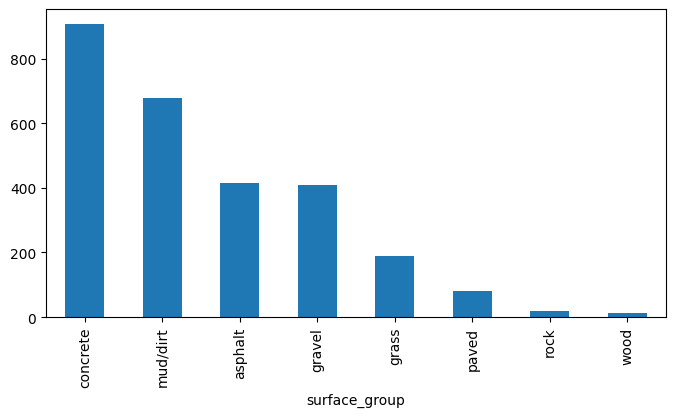

In [11]:
# ST_MakeEnvelope(<min_lon>, <min_lat>, <max_lon>, <max_lat>, 4326)
query = """
    SELECT osm_id, highway, surface, surface_group, tags, way, ST_Length(way) AS length_m
    FROM planet_osm_line
    WHERE (highway IN ('path', 'footway') OR route = 'hiking')
    AND ST_Length(way) > 1000
    AND surface IS NOT NULL
    AND surface_group IS NOT NULL
    """

gdf = gpd.read_postgis(query, engine, geom_col='way')
print(gdf.count())
# Convert to WGS84 so that the GeoJSON is in longitude/latitude
gdf = gdf.to_crs(epsg=4326)

# Simple bar chart of these frequencies
gdf['surface_group'].value_counts().plot.bar(figsize=(8, 4))

In [12]:
gdf.head(20)

osm_id  highway       surface surface_group  \
0    712112850  footway         paved         paved   
1    723850097     path        gravel        gravel   
2    288169759     path   fine_gravel        gravel   
3   1135181318     path         grass         grass   
4   1175367216     path  sand;pebbles        gravel   
5   1053447351  footway       asphalt       asphalt   
6   1308022964  footway       asphalt       asphalt   
7    120086092     path          dirt      mud/dirt   
8    162622097    track        gravel        gravel   
9    223837483  footway       asphalt       asphalt   
10  1004346564  footway       asphalt       asphalt   
11   623572701  footway       asphalt       asphalt   
12   621290586  footway       asphalt       asphalt   
13   964406874     path       asphalt       asphalt   
14  1163367102  footway       asphalt       asphalt   
15   210824581     path        gravel        gravel   
16   633741804  footway       asphalt       asphalt   
17    35334727  footway      concrete      concrete   
18   291199752     path        gravel        gravel   
19   467765859     path       asphalt       asphalt   

                                                 tags  \
0   {'footway': 'sidewalk', 'osm_uid': '0', 'osm_u...   
1   {'osm_uid': '0', 'osm_user': '', 'sac_scale': ...   
2   {'osm_uid': '0', 'osm_user': '', 'osm_version'...   
3   {'osm_uid': '0', 'osm_user': '', 'osm_version'...   
4   {'osm_uid': '0', 'osm_user': '', 'osm_version'...   
5   {'footway': 'sidewalk', 'osm_uid': '0', 'osm_u...   
6   {'footway': 'sidewalk', 'osm_uid': '0', 'osm_u...   
7   {'lit': 'no', 'osm_uid': '0', 'informal': 'yes...   
8   {'colour': '#008000', 'hiking': 'lwn', 'osm_ui...   
9   {'footway': 'sidewalk', 'osm_uid': '0', 'osm_u...   
10  {'footway': 'sidewalk', 'osm_uid': '0', 'osm_u...   
11  {'footway': 'sidewalk', 'osm_uid': '0', 'osm_u...   
12  {'lit': 'yes', 'footway': 'sidewalk', 'osm_uid...   
13  {'osm_uid': '0', 'osm_user': '', 'osm_version'...   
14  {'osm_uid': '0', 'osm_user': '', 'osm_version'...   
15  {'osm_uid': '0', 'osm_user': '', 'osm_version'...   
16  {'footway': 'sidewalk', 'osm_uid': '0', 'osm_u...   
17  {'lit': 'yes', 'kerb': 'yes', 'footway': 'side...   
18  {'osm_uid': '0', 'osm_user': '', 'osm_version'...   
19  {'osm_uid': '0', 'osm_user': '', 'osm_version'...   

                                                  way     length_m  
0   LINESTRING (-7.77351 55.02703, -7.77333 55.026...  1030.701684  
1   LINESTRING (-8.09003 55.02568, -8.09009 55.025...  1759.780217  
2   LINESTRING (-7.96771 55.03572, -7.96789 55.035...  2270.136507  
3   LINESTRING (-6.9062 53.73472, -6.90864 53.7350...  1881.796549  
4   LINESTRING (-5.8653 54.22562, -5.86523 54.2256...  1672.300535  
5   LINESTRING (-6.30579 54.27846, -6.30581 54.278...  1616.552597  
6   LINESTRING (-6.68627 55.11475, -6.68624 55.114...  1058.582714  
7   LINESTRING (-6.33986 53.35008, -6.34005 53.350...  1641.248659  
8   LINESTRING (-8.48463 54.20225, -8.48462 54.202...  2421.028482  
9   LINESTRING (-5.96241 54.69738, -5.96259 54.697...  2368.805681  
10  LINESTRING (-5.96155 54.69497, -5.9619 54.6950...  1392.586891  
11  LINESTRING (-5.89581 54.5306, -5.8958 54.53063...  1021.357087  
12  LINESTRING (-5.89069 54.5252, -5.89067 54.5252...  1191.171072  
13  LINESTRING (-6.17589 54.71583, -6.17301 54.716...  1082.395938  
14  LINESTRING (-5.94397 54.69549, -5.94378 54.695...  1410.721591  
15  LINESTRING (-6.2216 54.62514, -6.22154 54.6251...  1116.362712  
16  LINESTRING (-5.90966 54.54511, -5.90965 54.545...  1178.446981  
17  LINESTRING (-6.33914 53.27434, -6.34071 53.274...  1315.978796  
18  LINESTRING (-6.38435 54.49437, -6.38436 54.494...  1253.404797  
19  LINESTRING (-6.75883 54.49111, -6.75945 54.490...  1180.829403

In [13]:
!pip install sentinelhub geopandas rasterio matplotlib numpy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [14]:
from sentinelhub import SHConfig

config = SHConfig()

config.sh_client_id = 'f3101a77-1835-4be3-ae45-7e9f7c5ff738'
config.sh_client_secret = 'qTPPEOHdlEQdUUDcFZaYGFBpgYii1CWI'

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning: Please set your Sentinel Hub credentials.")


/Users/markfinlay/code/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, bbox_to_dimensions

# Define the area of interest (latitude, longitude bbox)
bbox = BBox(bbox=[-6.369, 53.001, -6.367, 53.000], crs=CRS.WGS84)

# Resolution of your imagery in meters
resolution = 10
size = bbox_to_dimensions(bbox, resolution=resolution)

# Sentinel-2 Cloudless data request
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  var factor = 4;  // Increase brightness by 50%
  return [
    Math.min(sample.B04 * factor, 1.0),
    Math.min(sample.B03 * factor, 1.0),
    Math.min(sample.B02 * factor, 1.0)
  ];
}
"""

request = SentinelHubRequest(
    data_folder='sentinel_data',
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2025-01-01', '2025-03-18'),
            mosaicking_order='leastCC'  # least cloud coverage
        )
    ],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)

image = request.get_data(save_data=True)[0]